In [1]:
import sys
sys.path.append("/home/rotation3/complex-coor-pred/")

import h5py
import time
import random
import torch
import numpy as np
from tools.align_svd import align_svd
from tools.cal_lddt_tensor import cal_lddt
from tools.sample_from_dataset import sample_only

plot_file = h5py.File("/home/rotation3/complex-coor-pred/data/plot_file.h5", "a")

protein_index_ls = []
initial_lddt_ls = []
final_lddt_ls = []
ideal_lddt_ls = []
print("===nohup_begin===")
for protein_index in [1800, 4720, 6560,10120, 4560, 7080, 13400, 13880, 5800, 840]:
# for protein_index in range(0,20000,400):
    # print("=========protein{}================".format(protein_index))
    train_file = h5py.File("/home/rotation3/complex-coor-pred/AlignCoorConfusion/h5py_data/train_dataset.h5py", "r")
    protein = train_file["protein"+str(protein_index)]

    _,_,label,_,pdb_index = sample_only(train_mode=True, index=protein_index)
    label = label[0]
    label = torch.from_numpy(np.array(label))
    pred_coor = torch.from_numpy(np.array(protein["pred_coor"]).squeeze())
    rotation_matrix = torch.from_numpy(np.array(protein["rotation_matrix"]).squeeze())
    trasslation_matrix = torch.from_numpy(np.array(protein["translation_matrix"]).squeeze())
    lddt_score = torch.from_numpy(np.array(protein["lddt_score"]).squeeze())

    stand_lddt = lddt_score[0].mean()  # 0.848
    initial_stand_lddt = stand_lddt.clone()
    lddt_score.mean()  # 0.782
    idea_lddt = lddt_score.max(axis=0).values.mean()   # 0.891

    index = lddt_score.argmax(axis=0)   # protein的每个位置对应的最大值的位置
    L = len(index)
    best_chain = pred_coor[0]  # chain代表一整条链；seq代表一个序列片断
    best_chain_guarantee = best_chain.clone()
    step = 0
    stop_step = 0
    beg = time.time()
    while step<500:
        if stop_step>25:
            break
        step += 1
        stop_step += 1
        # print("step {} begin".format(step+1))
        if L%2 == 0:
            m = L-1
        else:
            m = L
        CLAMP = random.choice(range(3,51,2))   # 这只是一种妥协的做法。其实可以通过另外一种方法将其更精确的Align到一起。
        half_clamp = int((CLAMP-1)/2)
        for i in range(L):
            if index[i] == 0:
                continue
            if i <= half_clamp:
                seq4align = pred_coor[index[i]][:CLAMP]
                model4align = best_chain[:CLAMP]
            elif (L-i) <= half_clamp:
                seq4align = pred_coor[index[i]][-CLAMP:]
                model4align = best_chain[-CLAMP:]
            else:
                seq4align = pred_coor[index[i]][i-half_clamp:i+half_clamp+1]
                model4align = best_chain[i-half_clamp:i+half_clamp+1]
            align_seq = align_svd(model4align, seq4align)
            best_chain_tmp = best_chain.clone()
            best_chain_tmp[i] = align_seq[half_clamp+1]
            lddt = cal_lddt(label, best_chain_tmp)   # 这里先使用真实的lddt，如果实验结果比较好，就再使用pLDDT
            if lddt > (stand_lddt+1e-5):
                best_chain = best_chain_tmp.clone()
                # print("improve!", (lddt-stand_lddt).item())
                stand_lddt = lddt
                # print("improved_lddt", stand_lddt.item())
                stop_step = 0
            elif lddt > (stand_lddt-1e-3):
                best_chain = best_chain_tmp.clone()
                # print("about…", lddt-stand_lddt)
        


    print("===METRIC===")
    final_lddt = cal_lddt(label, best_chain)
    if final_lddt < initial_stand_lddt:
        best_chain = best_chain_guarantee
        final_lddt = initial_stand_lddt
    print(best_chain.shape)
    protein = plot_file.create_group(pdb_index + "_confuse")
    protein["pred_coor"] = best_chain

    print("protein:", protein_index)
    print("initial lddt:", initial_stand_lddt)
    print("final lddt:", final_lddt)
    print("ideal lddt", idea_lddt)
    print("time useage", time.time()-beg)
    print("===END===\n")

    protein_index_ls.append(protein_index)
    initial_lddt_ls.append(initial_stand_lddt)
    final_lddt_ls.append(final_lddt)
    ideal_lddt_ls.append(idea_lddt)
    



===nohup_begin===
===METRIC===
torch.Size([76, 3])
protein: 1800
initial lddt: tensor(0.4756)
final lddt: tensor(0.7135)
ideal lddt tensor(0.5602)
time useage 15.211552619934082
===END===

===METRIC===
torch.Size([95, 3])
protein: 4720
initial lddt: tensor(0.2851)
final lddt: tensor(0.4879)
ideal lddt tensor(0.3886)
time useage 23.964104890823364
===END===

===METRIC===
torch.Size([106, 3])
protein: 6560
initial lddt: tensor(0.3848)
final lddt: tensor(0.5993)
ideal lddt tensor(0.4835)
time useage 33.609434366226196
===END===

===METRIC===
torch.Size([130, 3])
protein: 10120
initial lddt: tensor(0.3288)
final lddt: tensor(0.5018)
ideal lddt tensor(0.4646)
time useage 50.34951400756836
===END===

===METRIC===
torch.Size([94, 3])
protein: 4560
initial lddt: tensor(0.3635)
final lddt: tensor(0.5939)
ideal lddt tensor(0.4740)
time useage 36.28144979476929
===END===

===METRIC===
torch.Size([109, 3])
protein: 7080
initial lddt: tensor(0.3999)
final lddt: tensor(0.5313)
ideal lddt tensor(0.54

In [6]:
target_ls =  ['1fzcB01', '4na1B02', '2m9hA00', '1i16A00', '2miqA00', '3c0dA00', '4cs9A00', '2vsgA02', '1i1jB00', '3cnqP00']
for i in range(len(target_ls)):
    pdb_index = target_ls[i]
    print(pdb_index)
    lddt = final_lddt_ls[i]
    protein = plot_file[pdb_index]
    protein_conf = plot_file[pdb_index+'_confuse']
    if 'phipsi' in protein_conf.keys():
        del protein_conf['phipsi']
    protein_conf['phipsi'] = protein['phipsi']
    protein_conf['identity'] = str(protein['identity']) + '_confusion'
    protein_conf['lddt'] = lddt

1fzcB01
4na1B02
2m9hA00
1i16A00
2miqA00
3c0dA00
4cs9A00
2vsgA02
1i1jB00
3cnqP00


In [23]:
plot_file.close()

In [3]:

align_result = open("/home/rotation3/complex-coor-pred/AlignCoorSample/log/result.txt","w",encoding="utf-8")
align_result.write("index\tinitial_lddt\tfinal_lddt\tideal_lddt\n")
for i in range(len(protein_index_ls)):
    align_result.write(str(protein_index_ls[i]) + "\t")
    align_result.write(str(initial_lddt_ls[i]) + "\t")
    align_result.write(str(final_lddt_ls[i]) + "\t")
    align_result.write(str(ideal_lddt_ls[i]) + "\n")
align_result.close()


0.4239248
0.44374335
0.542276


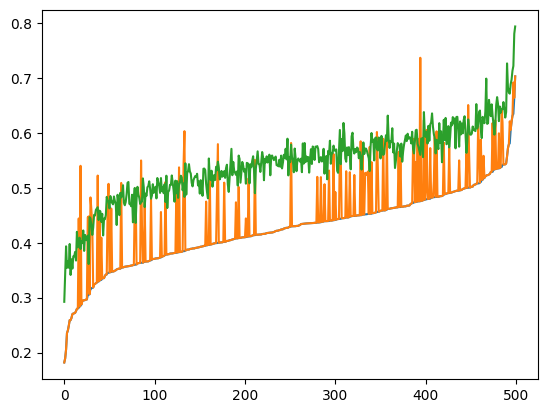

In [25]:
import seaborn as sns
import numpy as np

initial_lddt = np.array(initial_lddt_ls)
final_lddt = np.array(final_lddt_ls)
expected_lddt = np.array(ideal_lddt_ls)

np.save("/home/rotation3/complex-coor-pred/AlignCoorSample/initial_lddt.npy", initial_lddt)
np.save("/home/rotation3/complex-coor-pred/AlignCoorSample/final_lddt.npy", final_lddt)
np.save("/home/rotation3/complex-coor-pred/AlignCoorSample/expected_lddt.npy",expected_lddt)

sorted_initial_lddt = np.sort(initial_lddt)
index4sort = np.argsort(initial_lddt)
aligned_final_lddt = final_lddt[index4sort]
aligned_excepted_lddt = expected_lddt[index4sort]
sns.lineplot(sorted_initial_lddt)
sns.lineplot(aligned_final_lddt)
sns.lineplot(aligned_excepted_lddt)

print(initial_lddt.mean())
print(final_lddt.mean())
print(expected_lddt.mean())

In [23]:
diff_all = (final_lddt - initial_lddt)
diff_improved = (final_lddt - initial_lddt)[(final_lddt - initial_lddt)>1e-4]
print(diff_improved.__len__())   # 在500个蛋白质中，有91个蛋白质的LDDT得到了提升
print(len(diff_improved)/len(final_lddt))  # 占比18.2％
print(diff_improved.mean())  # 在这些蛋白质中，平均每个蛋白的LDDT_score提升了10.889个点
diff_all

### lddt_score有提升的位置
improve_index = np.nonzero(diff_all)[0]    # 放到整个train_dataloader中，还要×40
improve_lddt = diff_all[improve_index]
print(improve_lddt)

selected_initial_lddt = initial_lddt[improve_index]
print(selected_initial_lddt)

91
0.182
0.10889296
[0.05719209 0.13695747 0.08896172 0.15056038 0.1570755  0.14565253
 0.12185368 0.11552298 0.06247693 0.12061954 0.2612668  0.10064077
 0.09481412 0.1147145  0.11927021 0.0639376  0.06384963 0.08225197
 0.07686824 0.08893478 0.09213951 0.13060206 0.1456348  0.1423395
 0.13463658 0.11414257 0.10472891 0.18633664 0.14350367 0.255059
 0.09191996 0.07285073 0.16195336 0.10466343 0.11781788 0.10810822
 0.1317451  0.21841538 0.08125806 0.10782281 0.17968422 0.15450808
 0.04030627 0.15467298 0.07324508 0.1381217  0.10607603 0.05509442
 0.15220508 0.07749081 0.10782519 0.04119009 0.14239293 0.06314838
 0.13242662 0.08213058 0.19357729 0.10537398 0.10989371 0.06746781
 0.09281379 0.11323723 0.11210921 0.1155284  0.08432865 0.12644741
 0.09406409 0.1298922  0.16594657 0.08329386 0.12286359 0.16271508
 0.1332922  0.08131677 0.09310302 0.07579306 0.11189911 0.07435444
 0.07698888 0.06590185 0.11959434 0.07149917 0.02941054 0.08272365
 0.07716447 0.05068499 0.07994807 0.06746522 

<Axes: >

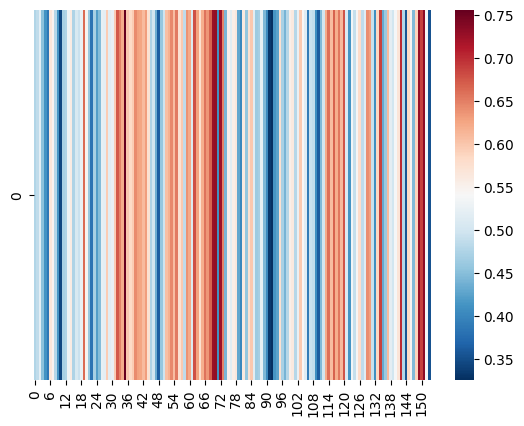

In [21]:
### 检查一下提升很高的序列，是在哪些部分有提升
index = 33

from tools.cal_lddt_tensor import cal_residue_lddt

protein_index = index*400
_,_,label,_ = sample_only(train_mode=True, index=protein_index)
label = label[0]
lddt = cal_residue_lddt(label, best_chain)
sns.heatmap(lddt.reshape(1,154),cmap="RdBu_r")